# review result after training

In [1]:
import matplotlib as plt
from scipy.io import loadmat
import pandas as pd

# load mat extension to dataframe
filename = 'grnn84030_1tid-0.000100a-48T-32D-2i-0.789000lr-7225ms-1b-52sn'
mat = loadmat(f'result/test/{filename}.mat')

In [2]:
mat['prediction']

array([[[[0.46119744],
         [0.46178526],
         [0.4614578 ],
         ...,
         [0.4608981 ],
         [0.46178526],
         [0.46178526]],

        [[0.07661991],
         [0.03156346],
         [0.01000991],
         ...,
         [0.03893905],
         [0.07017406],
         [0.06170716]],

        [[0.01153434],
         [0.11986233],
         [0.00082061],
         ...,
         [0.01419001],
         [0.0007273 ],
         [0.00781284]],

        ...,

        [[0.14147675],
         [0.1511708 ],
         [0.23685543],
         ...,
         [0.12326293],
         [0.11796642],
         [0.14187215]],

        [[0.14183235],
         [0.15109938],
         [0.21555226],
         ...,
         [0.12345087],
         [0.11828909],
         [0.13123839]],

        [[0.14144866],
         [0.15095176],
         [0.23687899],
         ...,
         [0.1232463 ],
         [0.11797465],
         [0.16094533]]]], dtype=float32)

In [3]:
mat['mseLoss']

array([[0.12813067, 0.01484721, 0.03011982, ..., 0.00487631, 0.0052207 ,
        0.00443839]], dtype=float32)

In [4]:
# flatten mat array to 1D
m_prediction = mat['prediction'].flatten()
m_mseloss = mat['mseLoss'].flatten()

# convert to pandas Series
prediction = pd.Series(m_prediction)
mseloss = pd.Series(m_mseloss)


In [7]:
# configure dataframe
df = pd.DataFrame({'prediction': prediction, 'mseloss': mseloss})
df.reset_index(drop=True)

df.head()

,prediction,mseloss
0,0.461197,0.128131
1,0.461785,0.014847
2,0.461458,0.030120
3,0.461785,0.019923
4,0.461785,0.072758


In [6]:
# output result to csv
df.to_csv(f'result/csv/{filename}.csv', header=None, index=False)

# --- annotate grnn ---

## model.py

In [ ]:
import torch
import torch.nn as nn

class AttrProxy(object):
    """
    Translates index lookups into attribute lookups.
    """
    def __init__(self, module, prefix):
        self.module = module
        self.prefix = prefix

    def __getitem__(self, i):
        return getattr(self.module, self.prefix + str(i))


class gruCell(nn.Module):
    def __init__(self, opt):
        super(gruCell, self).__init__()
        self.dimFeature = opt.dimFeature    # d
        self.dimHidden = opt.dimHidden      # D
        
        self.resetGate = nn.Sequential(
            nn.Linear(self.dimHidden + self.dimFeature, self.dimHidden),
            nn.Sigmoid()
        )
        self.updateGate = nn.Sequential(
            nn.Linear(self.dimHidden + self.dimFeature, self.dimHidden),
            nn.Sigmoid()
        )
        self.transform = nn.Sequential(
            nn.Linear(self.dimHidden + self.dimFeature, self.dimHidden),
            nn.Tanh()
        )
        self.output = nn.Linear(self.dimHidden, self.dimFeature)

    def forward(self, x, hState):
        i = torch.cat((hState, x), 1)
        z = self.resetGate(i)
        r = self.updateGate(i)
        jointI = torch.cat((r * hState, x), 1)
        hHat = self.transform(jointI)
        h = (1 - z) * hState + z * hHat
        o =  self.output(h)

        hState = h

        return o, hState


class Propogator(nn.Module):
    """
    Gated Propogator for GRNN
    Using GRU
    """
    def __init__(self, opt):
        super(Propogator, self).__init__()
        self.batchSize = opt.batchSize      # b
        self.nNode = opt.nNode              # n
        self.dimFeature = opt.dimFeature    # d
        self.dimHidden = opt.dimHidden      # D

        for i in range(self.nNode):
            cell = gruCell(opt)
            self.add_module("gruCell_{}".format(i), cell)

        self.cells = AttrProxy(self, "gruCell_")

    def forward(self, x, hState, A):
        O = torch.zeros(self.batchSize, self.nNode, self.dimFeature).double()
        H = torch.zeros(self.batchSize, self.dimHidden, self.nNode).double()
        S = torch.bmm(hState, A)

        for n in range(self.nNode):
            O[:, n, :], H[:, :, n] = self.cells[n](x[:, n, :], S[:, :, n])

        hState = H

        return O, hState


class GRNN(nn.Module):
    def __init__(self, opt):
        super(GRNN, self).__init__()
        self.batchSize = opt.batchSize      # b
        self.nNode = opt.nNode              # n
        self.dimFeature = opt.dimFeature    # d
        self.dimHidden = opt.dimHidden      # D
        self.interval = opt.truncate        # T

        self.propogator = Propogator(opt)

    def forward(self, x, hState, A):
        """
        x: input node features [batchSize, interval, nNode, dimFeature]
        hState: hidden state [batchSize, dimHidden, nNode]
        A: transfer matrix [nNode, nNode]
        """
        O = torch.zeros(self.batchSize, self.interval, self.nNode, self.dimFeature).double()

        # set propagator
        for t in range(self.interval):
            O[:, t, :, :], h = self.propogator(x[:, t, :, :], hState, A)
            hState = h

        return O, hState


## main.py

In [1]:
import argparse
import random
import datetime
import json

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# load other modules from project
from dataset import trafficDataLoader
from model import GRNN

# create timer
def getTime(begin, end):
    timeDelta = end - begin
    return '%d h %d m %d.%ds' % (timeDelta.seconds // 3600, (timeDelta.seconds%3600) // 60, timeDelta.seconds % 60, timeDelta.microseconds)

# start timer
timStart = datetime.datetime.now()

# get taskID, batchSize, dimHidden, lenBptt (BPTT length), nlternr (epoch
parser = argparse.ArgumentParser()
parser.add_argument('--taskID', type=int, default=1, help='traffic prediction task id')
parser.add_argument('--batchSize', type=int, default=1, help='input batch size')
parser.add_argument('--dimHidden', type=int, default=32, help='GRNN hidden state size')
parser.add_argument('--lenBptt', type=int, default=144, help='BPTT length for GRNN')
parser.add_argument('--epoch', type=int, default=2, help='number of epochs to train')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--cuda', action='store_true', help='enables cuda') # true = gpu, false = cpu
parser.add_argument('--verbal', action='store_true', help='print training info or not')
parser.add_argument('--manualSeed', type=int, help='manual seed')

# parse and store arguments from cli in opt
opt = parser.parse_args()
print(opt)

with open('./opt.save', 'w') as file:
     file.write(json.dumps(vars(opt)))

# construct CUDA before optimizer
if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000) # pick a random int between [1, 10000]
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)

#--------TEST---------
#data = data[:, 0]
#data = data[:, np.newaxis]
#A = np.array([1.])
#A = A[:, np.newaxis]
#opt.nNode = 1
#------TEST END-------

def main(opt):
    dataLoader = trafficDataLoader(opt.taskID)                 # load data using taskID

    data = np.transpose(dataLoader.data)                       # [T, n] where T = length of BPTT, n = nNode (number of edges)
    print(data)
    A = dataLoader.A                                           # load the linkage graph
    opt.nNode = dataLoader.nNode                               # load node
    A = A + np.eye(opt.nNode)                                  # return a 2d-array with ones on the diagonal and zeros elsewhere
    opt.dimFeature = 1                                         # n features

    data = torch.from_numpy(data[np.newaxis, :, :, np.newaxis]) # [b, T, n, d]
    A = torch.from_numpy(A[np.newaxis, :, :])                   # [b, n, n]

    # configure GRNN
    net = GRNN(opt) # pass in parsed agurments from cli into GRNN
    net.double() # increase precision needed for GRNN
    print(net)
    
    # set mse as loss metric
    criterion = nn.MSELoss()

    # enable GPU usage for GRNN, MSE, data, linkage graph
    if opt.cuda:
        net.cuda()                          # GPU 0
        criterion.cuda()                    # GPU 1
        data = data.cuda()                  # GPU 2
        A = A.cuda()                        # GPU 3
    
    # Adam optimizer updates the weights of the network iteratively based on the training dataset
    optimizer = optim.Adam(net.parameters(), lr=opt.lr) # optim.Adam([var1, var2], lr = 0.0001)

    # intialize hState.shape output: batchSize, dimHidden, nNode
    hState = torch.randn(opt.batchSize, opt.dimHidden, opt.nNode).double()
    
    # initialize last prediction
    yLastPred = 0 
    
    # configure plot
    plt.figure(1, figsize=(20, 5))
    plt.xlabel('?')
    plt.ylabel('speed m/s')
    plt.title('grnn prediction')
    plt.ion # turn interactive mode on
    
    ''' Beginning of Output '''
    
    # amount of training data
    # configure network dataset: [batchSize, interval, nNode (size of the linkage), dimFeature]
    for t in range(data.size(1) - opt.lenBptt):  # (4320 - 144 (or number of bptt length))
        x = data[:, t:(t + opt.lenBptt), :, :] # train timestep: 0, 1, 2, ..., 144 (default: trains for 1 day)
#         print(x)
        y = data[:, (t + 1):(t + opt.lenBptt + 1), :, :] # test timestep: 1, 2, 3, ..., 145
#         print(y)
        
        # configure rnn
        for i in range(opt.epoch):
            process = '[Log] %d propogation, %d epoch. ' % (t + 1, i + 1)
            
            timStamp = datetime.datetime.now() # forward current time
            prediction, hNew = net(x, hState, A) # grnn.propogator(x[:, t, :, :], hState, A)
            print(process + 'Forward used: %s.' % getTime(timStamp, datetime.datetime.now()))
            
            hState = hState.data
            loss = criterion(prediction, y) # store mse in loss
            optimizer.zero_grad() # clears x.grad for every parameter x in the optimizer
            
            timStamp = datetime.datetime.now() # backward current time
            loss.backward() # computes dloss/dx and accumulates into x.grad (by addition) for every parameter x
            print(process + 'Backward used: %s.' % getTime(timStamp, datetime.datetime.now()))
            
            optimizer.step() # updates the value of x using the gradient x.grad
        
        # define network feed-forward propagation
        _, hState = net.propogator(x[:, 0, :, :], hState, A)         # forward(x, hState, A)
        hState = hState.data
        
        if t == 0: # [batchSize, interval, nNode (size of the linkage), dimFeature]
            # plot x = timestep, y = actual speed in red
            plt.plot([v for v in range(opt.lenBptt)], x[:, :, 0, :].data.numpy().flatten(), 'r-', label='expected speed')
            
            # plot x = timestep + 1, y = predicted speed in blue
            plt.plot([v + 1 for v in range(opt.lenBptt)], prediction[:, :, 0, :].data.numpy().flatten(), 'b-', label='predicted speed')
        
        else:
            # plot x = timestep 1, 2, ..., y = actual speed in red
            plt.plot([t + opt.lenBptt - 2, t + opt.lenBptt - 1], x[:, -2:, 0, :].data.numpy().flatten(), 'r-', label='expected speed')
            
            plt.plot([t + opt.lenBptt - 1, t + opt.lenBptt], [yLastPred, prediction[0, -1, 0, 0]], 'b-', label='predicted speed')

        plt.draw()
        plt.pause(0.5) #plt.pause(interval_sec)
        
        # set yLastPred to new prediction[batchSize, interval, nNode, dimFeature]
        yLastPred = prediction[0, -1, 0, 0]

    plt.legend() # display plot legend
    plt.savefig('grnn_predict.jpg')
    plt.show()
    plt.ioff() # interactive mode off
    
    torch.save({
        'epoch', opt.epoch,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion
    }, './grnn.pt')
    
if __name__ == "__main__":
    main(opt)

SyntaxError: invalid syntax (<ipython-input-1-00dcfca1ccbd>, line 164)

## configure plot layout

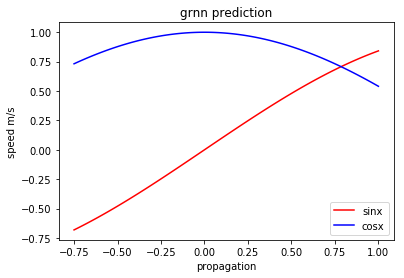

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# display plot within jupyter nb
%matplotlib inline

# setup pseudo-data
x = np.linspace(-0.75,1,100)
y1 = np.sin(x)
y2 = np.cos(x)

# plot
plt.plot(x, y1, 'r-', label='sinx')
plt.plot(x, y2, 'b-', label='cosx')

# configure plot appearance
plt.figure(1, figsize=(20, 5))
plt.xlabel('propagation')
plt.ylabel('speed m/s')
plt.title('grnn prediction')

plt.legend()
plt.savefig('sample.jpg')
plt.show()

## dataset.py

In [4]:
# todo: remove unused imports
import argparse
import random
import datetime
import json

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# load other modules from project
from dataset import trafficDataLoader
from model import GRNN

# load the opt file
opt = None
with open('opt.save') as f:
    opt = json.load(f)

print(opt)

net = GRNN(opt)
optimizer = optim.Adam(net.parameters(), lr=opt.lr) # optim.Adam([var1, var2], lr = 0.0001)

checkpoint = torch.load('./grnn.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# prediction mode
net.eval()

dataLoader = trafficDataLoader(opt.taskID)                 # load data using taskID

data = np.transpose(dataLoader.data) 

{'taskID': 1, 'batchSize': 1, 'dimHidden': 32, 'truncate': 1008, 'nItenr': 2, 'lr': 0.01, 'cuda': True, 'verbal': False, 'manualSeed': None}


## ---- utility functions ----

In [2]:
import pandas as pd
data_df = pd.read_csv('data/financial_district_jams.csv', dtype={'avg_speed':'float64', 'edge_index':'int64'}, 
                      converters={'pub_millis':pd.to_datetime})

# check how many null values exist within the dataset
data_df.isnull().any(axis=1).value_counts()

False    479520
dtype: int64

In [ ]:
# maps a specific index from the list of speeds to an edge tuples
def create_speed_index_to_edge_dict():
    segments = {}
    with open('../data/segments.csv') as in_file:
        for line in in_file:
            split_line = line.rstrip().split(',')

            # set the key of dict to be the edge tuple, and the value to be the row id
            segments[int(split_line[0])] = (int(split_line[1]), int(split_line[2]))

    selected_segments = {}
    line_num = 0
    with open('../data/selSegs_1.csv') as in_file:
        for line in in_file:
            split_line = line.rstrip().split(',')

            # set the key of dict to be the edge tuple, and the value to be the row id
            selected_segments[line_num] = segments[int(split_line[0])]
            line_num += 1
    
    return selected_segments

In [ ]:
import pandas as pd
import numpy ad np
def find_starting_time_index():
    # store the smallest time from the jams index to a file
    # read that file and return the smallest time (converted to datetime)
    
def convert_index_to_time(start_time):
    return start_time + np.timedelta64(10 * index, 'm')

In [ ]:
def find_actual_speed(time_index):
    data_df = pd.read_csv('data/financial_district_jams.csv', dtype={'avg_speed':'float64', 'edge_index':'int64'}, 
                      converters={'pub_millis':pd.to_datetime})

    # aggregate df by edge id and create a list of speeds for each edge id
    speed_list = data_df.groupby(['edge_index'])['avg_speed'].apply(list)
    
    return speed_list[time_index]